# `anns-00`: Parallel distributed processing

In this lab, we'll introduce several classical neural network models that reproduce simple cognitive phenomena. To complete some of the exercises, you'll need to install [PsyNeuLink](http://www.psyneuln.deptcpanel.princeton.edu/): `pip install psyneulink` (On Mac, you may need to first update `CommandLineTools` using `xcode-select --install`; ensure you're using Python version 3.9: `conda install python=3.9`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psyneulink as pnl

### Hopfield network
In this first exercise, we will perform pattern completion (i.e. associative memory) using a simple recurrent network. Hopfield networks [Hopfield, 1982](https://doi.org/10.1073/pnas.79.8.2554) are composed of binary units (e.g. taking values of either 1 or -1) depending on whether a unit's input(s) exceed a certain threshold. Here, we'll use a simple 25-unit Hopfield network to recognize the letters "**A**" and "**Z**". First, we'll set up 5-by-5 arrays visually representing each letter pattern. 

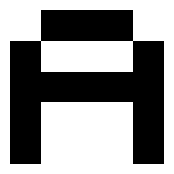

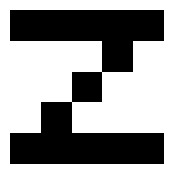

In [2]:
# Set up 5 x 5 letter patterns A and Z
shape = (5, 5)

A = np.array([
    [-1, 1, 1, 1, -1],
    [1, -1, - 1, -1, 1],
    [1, 1, 1, 1, 1],
    [1, -1, - 1, -1, 1],
    [1, -1, - 1, -1, 1]]).flatten()

Z = np.array([
    [1, 1, 1, 1, 1],
    [-1, -1, -1, 1, -1],
    [-1, -1, 1, -1, - 1],
    [-1, 1, -1, -1, -1],
    [1, 1, 1, 1, 1]]).flatten()

# Function to plot letter patterns
def plot_pattern(pattern):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.matshow(pattern.reshape(shape), cmap='binary')
    ax.set_axis_off()

plot_pattern(A)
plot_pattern(Z)

Next, we'll set up the connections between units in our network: a 25-by-25 weight matrix (initialized with zeros). Each unit is connected to all other units; we'll manually zero out the diagonal of the weight matrix to ensure that each unit isn't connnected to itself. Each unit corresponds to a "pixel" of the input letter patterns. To "train" the network, we supply each input pattern to the network and update the weights: mathematically, we compute the outer product of each pattern (comprising 1s and -1s) and simply add this to existing weights (effectively constructing a covariance matrix). This means that when units are coactivated, the strength of their connection increase—essentially Hebbian learning (Hebb, 1949).

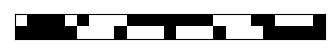

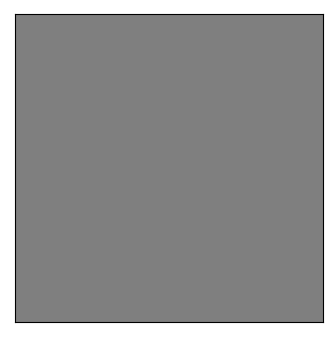

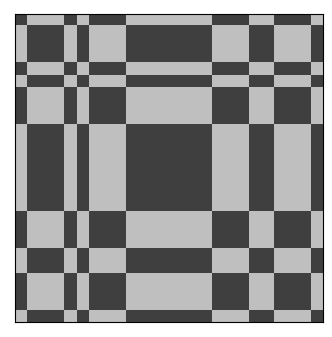

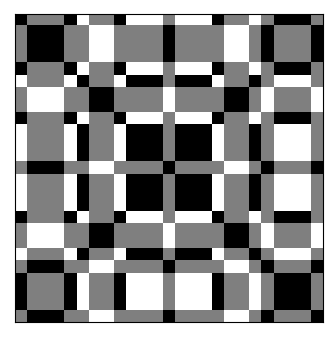

In [3]:
# Stack patterns and set variables
patterns = np.vstack([A, Z])
n_patterns, n_units = patterns.shape
fig, ax = plt.subplots(figsize=(4, 1))
ax.matshow(patterns, cmap='binary')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Initialize weight matrix at zero
weights = np.zeros((n_units, n_units))
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(weights, vmin=-1, vmax=1, cmap='binary')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Input each pattern and update weights
for pattern in patterns:
    weights += np.outer(pattern, pattern) / n_patterns
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(weights, vmin=-1, vmax=1, cmap='binary')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

# Remove self-connections by zeroing out diagonal weights
weights[np.diag_indices(n_units)] = 0    

Now that the network has "memorized" the input letters, we can examine how well it recognizes novel test letters. First, let's create a function that adds noise to existing letters to make this more of a challenge.

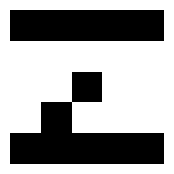

In [4]:
# Function to add binary (-1, 1) noise to letters
def pattern_noise(pattern, noise_level=.2):
    noise = np.random.choice(
        [1, -1], size=len(pattern), p=[1 - noise_level, noise_level])
    return pattern * noise

pattern_test = pattern_noise(Z, noise_level=.05)
plot_pattern(pattern_test)

The model will try to associate any input pattern with a pattern learned during training. For a given pattern, we'll allow the network to iterate on it a number of times. At each iteration, we'll compute the dot product between the pattern and the learned weight matrix, yielding a new pattern: a re-representation of the input pattern represented internally by the model's units after passing through the "transformation" implemented by the weight matrix. After a number of iterations, we'll return the final internal state of the model: the predicted pattern. Note that at this stage we keep the weights fixed.

In [5]:
# Pattern completion function
def pattern_complete(weights, pattern, n_iter=10, soft=False):

    # Supply pattern to weight matrix for each iteration
    patterns = []
    for i in np.arange(n_iter):
        pattern = np.dot(pattern, weights)
        
        # Threshold resulting pattern
        if soft:
            pattern = np.tanh(pattern)
        else:
            pattern[pattern < 0] = -1
            pattern[pattern >= 0] = 1

        # Store pattern at each iteration
        patterns.append(pattern)

    return(patterns)

Finally, we'll perform pattern completion. Create a new randomized test pattern and supply it to the pattern completion function. Plot the internal states of the network at each iteration.

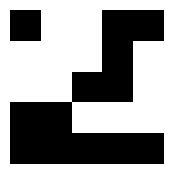

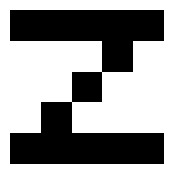

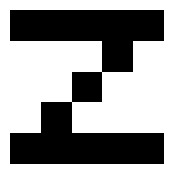

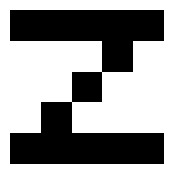

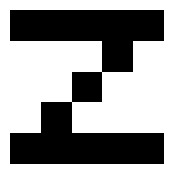

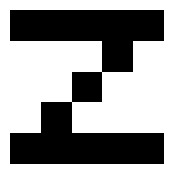

In [6]:
pattern_test = pattern_noise(Z, noise_level=.3)
plot_pattern(pattern_test)

n_iter = 5
patterns_pred = pattern_complete(weights, pattern_test, n_iter=n_iter)

for pattern_pred in patterns_pred:
    plot_pattern(pattern_pred)

### Perceptron
In this exercise, we'll construct a simple feedforward network—the perceptron—to implement "logical gates": binary classification problems of the form "are both A and B true?" The value $1$ corresponds to "True" and $0$ corresponds to "False". First, we'll set up all pairs of the two boolean values True and False. The "AND gate" should return True only when both pairs are True (i.e. `[1, 1]`) and False otherwise. The "OR gate" should return True when *any* element of a pair is True. We'll set up label vectors reflecting these logic gates.

In [7]:
# Define booleans
bools = np.array([(1, 1),
                  (1, 0),
                  (0, 1),
                  (0, 0)]).T
n_bools = bools.shape[1]

# Define labels for AND, OR
labels_and = np.array([1, 0, 0, 0])
labels_or = np.array([1, 1, 1, 0])

We'll begin with the simplest perceptron: the two input values (corresponding to the truth values of a given pair) are mapped through two weights to a single output unit ([McCulloch & Pitts, 1943](https://doi.org/10.1007/BF02478259); Rosenblatt, 1957). This output unit sums the inputs and responds True if it reaches a certain threshold and False otherwise. We'll introduce a fixed `bias` term simplify this threshold for the current example. We'll supply the model with pairs of truth values as input alongside their corresponding truth values for a given logic gate (start with the AND gate). At each iteration of learning, we'll supply the input pairs and the target labels and multiply them by the weights; if the predicted labels are incorrect, we'll adjust the weights according to the difference between the predicted and target labels (scaled by a learning rate `eta`). Track the accuracy of the logic gate at each iteration and plot the accuracies across iterations.

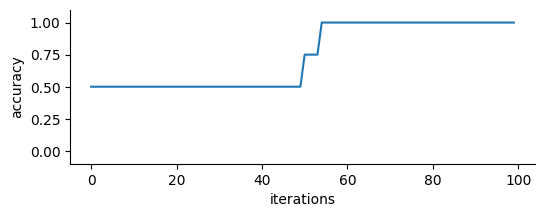

In [8]:
# Set which labels to learn
labels = labels_and
n_labels = len(labels)

# Initialize random weights, bias, and learning rate
weights = np.random.randn(1, 2) + 10
bias = -1
eta = np.array([.2, .2])
n_iter = 100

# Loop through iterations and fit model
accuracies = []
for i in np.arange(n_iter):
    
    # Loop through booleans/labels
    accuracy = 0
    for s in np.arange(n_labels):
        
        # Check whether input * weights yields correct label
        if weights @ bools[:, s] + bias <= 0:
            predicted_label = 0
        else:
            predicted_label = 1

        # Check for correct label
        if predicted_label == labels[s]:
            accuracy += 1

        # If incorrect, adjust weights accordingly
        else:
            diff = labels[s] - predicted_label
            weights = weights + eta * diff * bools[:, s].T

    # Record accuracy at each iteration
    accuracies.append(accuracy / n_labels)

# Plot accuracy across iterations
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(accuracies)
ax.set(xlabel='iterations', ylabel='accuracy', ylim=(-.1, 1.1),
       yticks=(0, .25, .5, .75, 1))
sns.despine()

The above perceptron functions as linear classifier and cannot solve nonlinear problems. For example, try using the above perceptron as an "XOR gate": the "exclusive-or" gate only returns True when one element of a given pair is True, but not when both are true. This limitation stymied work on neural networks for years. The solution to this problem is to introduce a hidden layer comprising one or more units with thresholds between the input and output units. However, training a multilayer perceptron (MLP) like this is more difficult. In the following exercise, we first reconstruct the simple single-layer perceptron above using [PsyNeuLink](http://www.psyneuln.deptcpanel.princeton.edu/). We'll add a third constant value of $1$ to each input corresponding to a bias term used above.

In [9]:
# Define booleans with built-in bias term
bools = np.array([[1,1,1],[1,0,1],[0,1,1],[0,0,1]])
bools_dim = bools.shape[1]

# Define labels for AND, OR, XOR
labels_and = np.array([1, 0, 0, 0])
labels_or = np.array([1, 1, 1, 0])
labels_xor = np.array([0, 1, 1, 0])

In PsyNeuLink, we first construct an input layer (that simply supplies the input to the weights) and an output layer comprising one unit with a logistic activation function. We then initialize a random weight matrix mapping from the input to the output unit. We'll use PsyNeuLink's `AutodiffComposition` to update the weights using backpropagation. Finally, we'll track the loss—i.e. how badly the predictions mismatch the target labels—over the coures of training. Plot the loss across iterations for the AND and OR gates. Note that this simple perceptron will *still* not be able to solve the XOR problem.

Output()

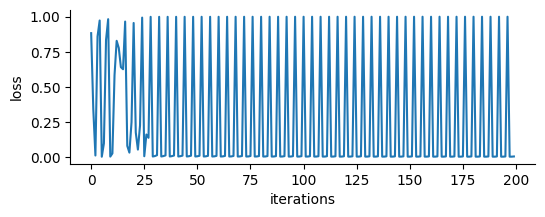

In [10]:
# Set which labels to learn
labels = labels_xor

# Define input and output layers
in_layer=pnl.TransferMechanism(size=bools_dim, function=pnl.Linear)
out_layer=pnl.TransferMechanism(size=1, function=pnl.Logistic)

# Create random weights mapping from input to output
weights = pnl.MappingProjection(name='in_to_out',
    matrix=np.random.randn(bools_dim, 1),
    sender=in_layer,
    receiver=out_layer)

# Compose into two-layer network with backpropagation
logic_2layer = pnl.AutodiffComposition(
    learning_rate=10)
logic_2layer.add_node(in_layer)
logic_2layer.add_node(out_layer)

# Set up projection from input layer to output layer
logic_2layer.add_projection(sender=in_layer,
    projection=weights,
    receiver=out_layer)

# Ensure logging
out_layer.log.set_log_conditions(pnl.VALUE)

# Define inputs and targets
input_dict = {"inputs": {in_layer: bools},
              "targets": {out_layer: labels},
              "epochs": 50}

# Fit the network!
result = logic_2layer.learn(inputs=input_dict)

# Extract loss across iterations
exec_id = logic_2layer.default_execution_id
losses = logic_2layer.parameters.losses.get(exec_id)

# Plot loss across iterations
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(losses)
ax.set(xlabel='iterations', ylabel='loss')
sns.despine()

Lastly, we'll introduce a hidden layer with a logistic activation function between our input and output. Critically, backpropagation allows us to effectively update the weights of this network. Weights connecting to output units are updated based on their mismatch between the predicted and target labels; weights connecting to hidden units are updated based on the sum of errors on all units receiving input from a given hidden unit. This network should be able to solve the nonlinear XOR problem.

Output()

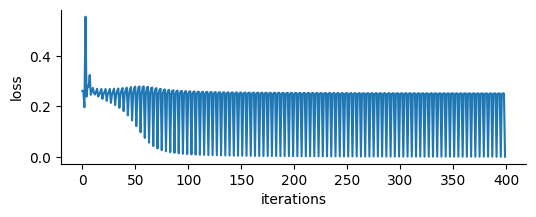

In [11]:
# Set which labels to learn
labels = labels_xor

# Define input, hidden, and output layers
in_layer=pnl.TransferMechanism(size=bools_dim, function=pnl.Linear)
hidden_layer=pnl.TransferMechanism(size=1, function=pnl.Logistic)
out_layer=pnl.TransferMechanism(size=1, function=pnl.Logistic)

# Create random weights mapping from input to hidden layer
in_weights = pnl.MappingProjection(name='in_to_hidden',
    matrix=np.random.randn(bools_dim, 1),
    sender=in_layer,
    receiver=hidden_layer)

# Create random weights mapping from hidden to output layer
out_weights = pnl.MappingProjection(name='hidden_to_out',
    matrix=np.random.randn(1, 1),
    sender=hidden_layer,
    receiver=out_layer)

# Compose into three-layer network with backpropagation
logic_3layer = pnl.AutodiffComposition(
    learning_rate=10)
logic_3layer.add_node(in_layer)
logic_3layer.add_node(hidden_layer)
logic_3layer.add_node(out_layer)

# Set up projection from input, to hidden, to output layer
logic_3layer.add_projection(sender=in_layer,
    projection=in_weights,
    receiver=hidden_layer)
logic_3layer.add_projection(sender=hidden_layer,
    projection=out_weights,
    receiver=out_layer)

# Ensure logging
out_layer.log.set_log_conditions(pnl.VALUE)

# Define inputs and targets
input_dict = {'inputs': {in_layer: bools},
              'targets': {out_layer: labels},
              'epochs': 100}

# Fit the network!
result = logic_3layer.learn(inputs=input_dict)

# Extract loss across iterations
exec_id = logic_3layer.default_execution_id
losses = logic_3layer.parameters.losses.get(exec_id)

# Plot loss across iterations
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(losses)
ax.set(xlabel='iterations', ylabel='loss')
sns.despine()

### Rumelhart's semantic network
In the final exercise, we'll construct a multilayer feedforward network that can assign semantic features to a given noun. For example, the network can tell us that an ***oak*** ***is*** → a ***living thing*** and an ***oak*** ***has*** → ***bark***, where "*oak is*" and "*oak has*" are inputs to the network and "*living thing*" and "*bark*" are outputs ([Rumelhart et al., 1986](https://doi.org/10.1038/323533a0); [McClelland & Rogers, 2003](https://doi.org/10.1038/nrn1076)). We'll first construct our nouns, relations, and semantic features.

In [12]:
# Create semantic nouns and relations
nouns = ['oak', 'pine', 'rose', 'daisy',
         'canary', 'robin', 'salmon', 'sunfish']

relations = ['is', 'has', 'can']

is_list = ['living', 'living thing', 'plant', 'animal', 'tree', 'flower',
           'bird', 'fish', 'big', 'green', 'red', 'yellow']

has_list = ['roots', 'leaves', 'bark', 'branches', 'skin',
            'feathers', 'wings', 'gills', 'scales']

can_list = ['grow', 'move', 'swim', 'fly', 'breathe', 'breathe underwater',
            'breathe air', 'walk', 'photosynthesize']

descriptors = [nouns, is_list, has_list, can_list]

# Set truth values for nouns and relations
truth_nouns = np.identity(len(nouns))

truth_is = np.zeros((len(nouns), len(is_list)))

truth_is[0, :] = [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
truth_is[1, :] = [1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0]
truth_is[2, :] = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
truth_is[3, :] = [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
truth_is[4, :] = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
truth_is[5, :] = [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
truth_is[6, :] = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]
truth_is[7, :] = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]

truth_has = np.zeros((len(nouns), len(has_list)))

truth_has[0, :] = [1, 1, 1, 1, 0, 0, 0, 0, 0]
truth_has[1, :] = [1, 1, 1, 1, 0, 0, 0, 0, 0]
truth_has[2, :] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
truth_has[3, :] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
truth_has[4, :] = [0, 0, 0, 0, 1, 1, 1, 0, 0]
truth_has[5, :] = [0, 0, 0, 0, 1, 1, 1, 0, 0]
truth_has[6, :] = [0, 0, 0, 0, 0, 0, 0, 1, 1]
truth_has[7, :] = [0, 0, 0, 0, 0, 0, 0, 1, 1]

truth_can = np.zeros((len(nouns), len(can_list)))

truth_can[0, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[1, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[2, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[3, :] = [1, 0, 0, 0, 0, 0, 0, 0, 1]
truth_can[4, :] = [1, 1, 0, 1, 1, 0, 1, 1, 0]
truth_can[5, :] = [1, 1, 0, 1, 1, 0, 1, 1, 0]
truth_can[6, :] = [1, 1, 1, 0, 1, 1, 0, 0, 0]
truth_can[7, :] = [1, 1, 1, 0, 1, 1, 0, 0, 0]

truths = [[truth_nouns], [truth_is], [truth_has], [truth_can]]

In [13]:
# Compile one-hot nouns and relations for input (with bias)
def compile_inputs(nouns, relations):
    input_nouns = np.vstack((np.identity(len(nouns)),
                             np.ones((1, len(nouns))))).T

    input_relations = np.vstack((np.identity(len(relations)),
                                 np.ones((1, len(relations))))).T
    return input_nouns, input_relations

input_nouns, input_relations = compile_inputs(nouns, relations)

nouns_dim = input_nouns.shape[1]
relations_dim = input_relations.shape[1]

Next, we'll construct the network. There are two input layers comprising the nouns (e.g. *oak*) and the relations (e.g. *is*, *has*). The noun inputs are first fed into a dedicated hidden layer, then this layer feeds into a second *mixed* hidden layer. The relation inputs are fed directly into the mixed hidden layer. Here, we use a 16-unit mixed hidden layer. This mixed hidden layer then feeds into three different sets of output units corresponding to the three different relations.

In [14]:
# Number of mixed hidden units from Rumelhart's paper
n_mixed = 16

# Create input, hidden, and output layers
in_nouns = pnl.TransferMechanism(name="in_nouns",
    default_variable=np.zeros(nouns_dim))

in_relations = pnl.TransferMechanism(name="in_relations", 
    default_variable=np.zeros(relations_dim))

hidden_nouns = pnl.TransferMechanism(name="hidden_nouns",
    size=nouns_dim, function=pnl.Logistic())

hidden_mixed = pnl.TransferMechanism(name="hidden_mixed",
    size=n_mixed, function=pnl.Logistic())

out_nouns = pnl.TransferMechanism(name="out_nouns",
    size=len(nouns), function=pnl.Logistic())

out_is = pnl.TransferMechanism(name="out_is",
    size=len(is_list), function=pnl.Logistic())

out_has = pnl.TransferMechanism(name="out_has",
    size=len(has_list), function=pnl.Logistic())

out_can = pnl.TransferMechanism(name="out_can",
    size=len(can_list), function=pnl.Logistic())

In [15]:
# Initialize random weight matrices between layers
w_nouns_hn = pnl.MappingProjection(
    matrix=np.random.randn(nouns_dim, nouns_dim),
    name="w_nouns_hn", sender=in_nouns, receiver=hidden_nouns)

w_rels_hm = pnl.MappingProjection(
    matrix=np.random.randn(relations_dim, n_mixed),
    name="w_rels_hm", sender=in_relations, receiver=hidden_mixed)

w_hn_hm = pnl.MappingProjection(
    matrix=np.random.rand(nouns_dim, n_mixed),
    name="w_hn_hm", sender=hidden_nouns, receiver=hidden_mixed)

w_hm_nouns = pnl.MappingProjection(
    matrix=np.random.randn(n_mixed, len(nouns)),
    name="w_hm_nouns", sender=hidden_mixed, receiver=out_nouns)

w_hm_is = pnl.MappingProjection(
    matrix=np.random.randn(n_mixed, len(is_list)),
    name="w_hm_is", sender=hidden_mixed, receiver=out_is)

w_hm_has = pnl.MappingProjection(
    matrix=np.random.randn(n_mixed, len(has_list)),
    name="w_hm_has", sender=hidden_mixed, receiver=out_has)

w_hm_can = pnl.MappingProjection(
    matrix=np.random.randn(n_mixed, len(can_list)),
    name="w_hm_can", sender=hidden_mixed, receiver=out_can)

In [16]:
# Compose multilayer network with backpropagation
RumelNet = pnl.AutodiffComposition(learning_rate=1)

# Add previously defined input, hidden, and output layers
RumelNet.add_node(in_nouns)
RumelNet.add_node(in_relations)
RumelNet.add_node(hidden_nouns)
RumelNet.add_node(hidden_mixed)
RumelNet.add_node(out_nouns)
RumelNet.add_node(out_is)
RumelNet.add_node(out_has)
RumelNet.add_node(out_can)

# Add weight matrices mapping between layers
RumelNet.add_projection(sender=in_nouns,
    projection=w_nouns_hn, receiver=hidden_nouns)
RumelNet.add_projection(sender=in_relations,
    projection=w_rels_hm, receiver=hidden_mixed)
RumelNet.add_projection(sender=hidden_nouns,
    projection=w_hn_hm, receiver=hidden_mixed)
RumelNet.add_projection(sender=hidden_mixed,
    projection=w_hm_nouns, receiver=out_nouns)
RumelNet.add_projection(sender=hidden_mixed,
    projection=w_hm_is, receiver=out_is)
RumelNet.add_projection(sender=hidden_mixed,
    projection=w_hm_has, receiver=out_has)
RumelNet.add_projection(sender=hidden_mixed,
    projection=w_hm_can, receiver=out_can)

out_nouns.log.set_log_conditions(pnl.VALUE)
out_is.log.set_log_conditions(pnl.VALUE)
out_has.log.set_log_conditions(pnl.VALUE)
out_can.log.set_log_conditions(pnl.VALUE)

In [17]:
# Set 'irrelevant' outputs when relation is not relevant
irrel_is = np.ones((len(nouns), len(is_list))) * .5
irrel_has = np.ones((len(nouns), len(has_list))) * .5
irrel_can = np.ones((len(nouns), len(can_list))) * .5

In [18]:
# Compile inputs and target outputs
inputs_dict = {in_nouns: [],
               in_relations: []}
targets_dict = {out_nouns: [],
                out_is: [],
                out_has: [],
                out_can: []}

for n in np.arange(len(nouns)):
    for r, relation in enumerate(relations):
        
        target_is = irrel_is[n]
        target_has = irrel_has[n]
        target_can = irrel_can[n]
        
        if relation == 'is':
            target_is = truth_is[n]
        elif relation == 'has':
            target_has = truth_has[n]
        elif relation == 'can':
            target_can = truth_can[n]
    
        inputs_dict[in_nouns].append(input_nouns[n])
        inputs_dict[in_relations].append(input_relations[r])
        
        targets_dict[out_nouns].append(truth_nouns[n])
        targets_dict[out_is].append(target_is)
        targets_dict[out_has].append(target_has)
        targets_dict[out_can].append(target_can)

Finally, we train the network. We'll plot the loss over iterations for correctly assigning semantic features given noun and relation inputs.

In [19]:
n_epochs = 5
n_iter = 200

# Train the network!
for i in np.arange(n_iter):
    result = RumelNet.learn(inputs=[{'inputs': inputs_dict,
                                     'targets': targets_dict,
                                     'epochs': n_epochs}])
    print(f"Finished training iteration {i}")

Output()

Finished training iteration 0


Output()

Finished training iteration 1


Output()

Finished training iteration 2


Output()

Finished training iteration 3


Output()

Finished training iteration 4


Output()

Finished training iteration 5


Output()

Finished training iteration 6


Output()

Finished training iteration 7


Output()

Finished training iteration 8


Output()

Finished training iteration 9


Output()

Finished training iteration 10


Output()

Finished training iteration 11


Output()

Finished training iteration 12


Output()

Finished training iteration 13


Output()

Finished training iteration 14


Output()

Finished training iteration 15


Output()

Finished training iteration 16


Output()

Finished training iteration 17


Output()

Finished training iteration 18


Output()

Finished training iteration 19


Output()

Finished training iteration 20


Output()

Finished training iteration 21


Output()

Finished training iteration 22


Output()

Finished training iteration 23


Output()

Finished training iteration 24


Output()

Finished training iteration 25


Output()

Finished training iteration 26


Output()

Finished training iteration 27


Output()

Finished training iteration 28


Output()

Finished training iteration 29


Output()

Finished training iteration 30


Output()

Finished training iteration 31


Output()

Finished training iteration 32


Output()

Finished training iteration 33


Output()

Finished training iteration 34


Output()

Finished training iteration 35


Output()

Finished training iteration 36


Output()

Finished training iteration 37


Output()

Finished training iteration 38


Output()

Finished training iteration 39


Output()

Finished training iteration 40


Output()

Finished training iteration 41


Output()

Finished training iteration 42


Output()

Finished training iteration 43


Output()

Finished training iteration 44


Output()

Finished training iteration 45


Output()

Finished training iteration 46


Output()

Finished training iteration 47


Output()

Finished training iteration 48


Output()

Finished training iteration 49


Output()

Finished training iteration 50


Output()

Finished training iteration 51


Output()

Finished training iteration 52


Output()

Finished training iteration 53


Output()

Finished training iteration 54


Output()

Finished training iteration 55


Output()

Finished training iteration 56


Output()

Finished training iteration 57


Output()

Finished training iteration 58


Output()

Finished training iteration 59


Output()

Finished training iteration 60


Output()

Finished training iteration 61


Output()

Finished training iteration 62


Output()

Finished training iteration 63


Output()

Finished training iteration 64


Output()

Finished training iteration 65


Output()

Finished training iteration 66


Output()

Finished training iteration 67


Output()

Finished training iteration 68


Output()

Finished training iteration 69


Output()

Finished training iteration 70


Output()

Finished training iteration 71


Output()

Finished training iteration 72


Output()

Finished training iteration 73


Output()

Finished training iteration 74


Output()

Finished training iteration 75


Output()

Finished training iteration 76


Output()

Finished training iteration 77


Output()

Finished training iteration 78


Output()

Finished training iteration 79


Output()

Finished training iteration 80


Output()

Finished training iteration 81


Output()

Finished training iteration 82


Output()

Finished training iteration 83


Output()

Finished training iteration 84


Output()

Finished training iteration 85


Output()

Finished training iteration 86


Output()

Finished training iteration 87


Output()

Finished training iteration 88


Output()

Finished training iteration 89


Output()

Finished training iteration 90


Output()

Finished training iteration 91


Output()

Finished training iteration 92


Output()

Finished training iteration 93


Output()

Finished training iteration 94


Output()

Finished training iteration 95


Output()

Finished training iteration 96


Output()

Finished training iteration 97


Output()

Finished training iteration 98


Output()

Finished training iteration 99


Output()

Finished training iteration 100


Output()

Finished training iteration 101


Output()

Finished training iteration 102


Output()

Finished training iteration 103


Output()

Finished training iteration 104


Output()

Finished training iteration 105


Output()

Finished training iteration 106


Output()

Finished training iteration 107


Output()

Finished training iteration 108


Output()

Finished training iteration 109


Output()

Finished training iteration 110


Output()

Finished training iteration 111


Output()

Finished training iteration 112


Output()

Finished training iteration 113


Output()

Finished training iteration 114


Output()

Finished training iteration 115


Output()

Finished training iteration 116


Output()

Finished training iteration 117


Output()

Finished training iteration 118


Output()

Finished training iteration 119


Output()

Finished training iteration 120


Output()

Finished training iteration 121


Output()

Finished training iteration 122


Output()

Finished training iteration 123


Output()

Finished training iteration 124


Output()

Finished training iteration 125


Output()

Finished training iteration 126


Output()

Finished training iteration 127


Output()

Finished training iteration 128


Output()

Finished training iteration 129


Output()

Finished training iteration 130


Output()

Finished training iteration 131


Output()

Finished training iteration 132


Output()

Finished training iteration 133


Output()

Finished training iteration 134


Output()

Finished training iteration 135


Output()

Finished training iteration 136


Output()

Finished training iteration 137


Output()

Finished training iteration 138


Output()

Finished training iteration 139


Output()

Finished training iteration 140


Output()

Finished training iteration 141


Output()

Finished training iteration 142


Output()

Finished training iteration 143


Output()

Finished training iteration 144


Output()

Finished training iteration 145


Output()

Finished training iteration 146


Output()

Finished training iteration 147


Output()

Finished training iteration 148


Output()

Finished training iteration 149


Output()

Finished training iteration 150


Output()

Finished training iteration 151


Output()

Finished training iteration 152


Output()

Finished training iteration 153


Output()

Finished training iteration 154


Output()

Finished training iteration 155


Output()

Finished training iteration 156


Output()

Finished training iteration 157


Output()

Finished training iteration 158


Output()

Finished training iteration 159


Output()

Finished training iteration 160


Output()

Finished training iteration 161


Output()

Finished training iteration 162


Output()

Finished training iteration 163


Output()

Finished training iteration 164


Output()

Finished training iteration 165


Output()

Finished training iteration 166


Output()

Finished training iteration 167


Output()

Finished training iteration 168


Output()

Finished training iteration 169


Output()

Finished training iteration 170


Output()

Finished training iteration 171


Output()

Finished training iteration 172


Output()

Finished training iteration 173


Output()

Finished training iteration 174


Output()

Finished training iteration 175


Output()

Finished training iteration 176


Output()

Finished training iteration 177


Output()

Finished training iteration 178


Output()

Finished training iteration 179


Output()

Finished training iteration 180


Output()

Finished training iteration 181


Output()

Finished training iteration 182


Output()

Finished training iteration 183


Output()

Finished training iteration 184


Output()

Finished training iteration 185


Output()

Finished training iteration 186


Output()

Finished training iteration 187


Output()

Finished training iteration 188


Output()

Finished training iteration 189


Output()

Finished training iteration 190


Output()

Finished training iteration 191


Output()

Finished training iteration 192


Output()

Finished training iteration 193


Output()

Finished training iteration 194


Output()

Finished training iteration 195


Output()

Finished training iteration 196


Output()

Finished training iteration 197


Output()

Finished training iteration 198


Output()

Finished training iteration 199


Final loss: 0.005529235624645281


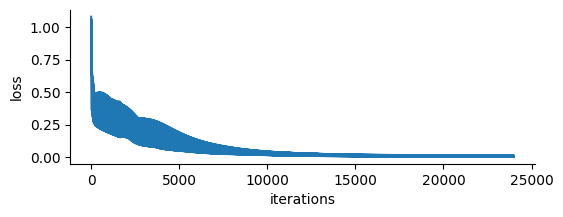

In [20]:
# Extract loss per update
exec_id = RumelNet.default_execution_id
losses = RumelNet.parameters.losses.get(exec_id)
print(f"Final loss: {losses[-1]}")

# Plot loss across iterations
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(losses)
ax.set(xlabel='iterations', ylabel='loss')
sns.despine()

#### References
* Hebb, D. O. (1949). *The Organization of Behavior*. New York: Wiley & Sons.

* Hopfield, J. J. (1982). Neural networks and physical systems with emergent collective computational abilities. *Proceedings of the National Academy of Sciences*, *79*(8), 2554–2558. https://doi.org/10.1073/pnas.79.8.2554

* McClelland, J. L., & Rogers, T. T. (2003). The parallel distributed processing approach to semantic cognition. Nature Reviews Neuroscience*, *4*(4), 310–322. https://doi.org/10.1038/nrn1076

* McCulloch, W. S., & Pitts, W. (1943). A logical calculus of the ideas immanent in nervous activity. *Bulletin of Mathematical Biophysics*, *5*, 115–133. https://doi.org/10.1007/BF02478259

* Rosenblatt, F. (1957). The Perceptron—a perceiving and recognizing automaton. Report 85-460-1. Cornell Aeronautical Laboratory.

* Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning representations by back-propagating errors. *Nature*, *323*(6088), 533–536. https://doi.org/10.1038/323533a0